# 07 - City Service Effectiveness

Measure how effectively cities deliver services using education, crime, and health metrics.

**Metrics:**
- Education: Census ACS (bachelor's degree %, HS graduation rate %)
- Safety: FBI UCR violent crime rates per 100K
- Health: CDC PLACES health index

**Output:** `city_effectiveness.csv`, `city_effectiveness.json`

In [1]:
import sys, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

sys.path.insert(0, str(Path("..").resolve()))
from src.city_data_utils import (
    get_top_100_cities, fetch_city_education_data,
    fetch_city_crime_data, fetch_city_health_data,
)

PROCESSED_DIR = Path("../data/processed")
CHARTS_DIR = Path("../docs/charts/data")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
CHARTS_DIR.mkdir(parents=True, exist_ok=True)

cities = get_top_100_cities()
print(f"{len(cities)} cities loaded")

100 cities loaded


In [2]:
def normalize_to_100(series, invert=False):
    """Min-max normalize a series to 0-100."""
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return pd.Series(50.0, index=series.index)
    normalized = (series - min_val) / (max_val - min_val) * 100
    if invert:
        normalized = 100 - normalized
    return normalized

# Fetch education data
education = fetch_city_education_data()
print(f"Education data: {len(education)} cities")
print(f"Bachelor's % range: {education['bachelors_pct'].min():.1f}% \u2013 {education['bachelors_pct'].max():.1f}%")
print(f"HS grad % range: {education['hs_grad_pct'].min():.1f}% \u2013 {education['hs_grad_pct'].max():.1f}%")
education.sort_values("bachelors_pct", ascending=False).head(10)

Using embedded Census ACS city education data
Education data: 100 cities
Bachelor's % range: 12.4% – 68.1%
HS grad % range: 58.7% – 96.1%


,city_state,bachelors_pct,hs_grad_pct
61,"Irvine, CA",68.1,95.8
17,"Seattle, WA",64.7,94.1
20,"Washington, DC",59.8,90.1
86,"Scottsdale, AZ",59.4,96.1
16,"San Francisco, CA",58.8,88.4
78,"Madison, WI",57.4,94.8
89,"Fremont, CA",56.7,91.4
73,"Plano, TX",54.8,93.7
35,"Atlanta, GA",53.4,89.8
10,"Austin, TX",53.4,89.1


In [3]:
# Fetch crime data
crime = fetch_city_crime_data()
print(f"Crime data: {len(crime)} cities")
print(f"Violent crime rate range: {crime['violent_crime'].min():.0f} \u2013 {crime['violent_crime'].max():.0f} per 100K")
crime.sort_values("violent_crime", ascending=False).head(10)

Using embedded FBI UCR city crime data
Crime data: 100 cities
Violent crime rate range: 76 – 2155 per 100K


,city_state,violent_crime
26,"Memphis, TN",2155
66,"St. Louis, MO",1927
36,"Kansas City, MO",1654
52,"Cleveland, OH",1517
28,"Baltimore, MD",1456
29,"Milwaukee, WI",1332
56,"Stockton, CA",1287
93,"San Bernardino, CA",1234
30,"Albuquerque, NM",1225
43,"Oakland, CA",1123


In [4]:
# Fetch health data
health = fetch_city_health_data()
print(f"Health data: {len(health)} cities")
print(f"Health index range: {health['health_index'].min():.0f} \u2013 {health['health_index'].max():.0f}")
health.sort_values("health_index", ascending=False).head(10)

Using embedded CDC PLACES city health data
Health data: 100 cities
Health index range: 50 – 80


,city_state,health_index
61,"Irvine, CA",80
86,"Scottsdale, AZ",78
89,"Fremont, CA",78
16,"San Francisco, CA",78
17,"Seattle, WA",77
78,"Madison, WI",77
55,"Honolulu, HI",76
75,"Gilbert, AZ",76
12,"San Jose, CA",76
73,"Plano, TX",74


In [ ]:
# Merge all metrics and compute composite using z-scores
effectiveness = cities.merge(education, on="city_state", how="inner") \
    .merge(crime, on="city_state", how="inner") \
    .merge(health, on="city_state", how="inner")

# Z-score each sub-metric, inverting where lower=better
def zscore(series, invert=False):
    """Z-score a series. Invert if lower raw values are better."""
    s = -series if invert else series
    return (s - s.mean()) / s.std()

# Education: z-score both bachelor's and HS grad rates, average them
effectiveness["bachelors_z"] = zscore(effectiveness["bachelors_pct"])
effectiveness["hs_z"] = zscore(effectiveness["hs_grad_pct"])
effectiveness["education_z"] = (effectiveness["bachelors_z"] + effectiveness["hs_z"]) / 2

# Safety: inverted crime rate (lower crime = better)
effectiveness["safety_z"] = zscore(effectiveness["violent_crime"], invert=True)

# Health: health index (higher = better)
effectiveness["health_z"] = zscore(effectiveness["health_index"])

# Composite = average of z-scores (raw, not yet scaled to 0-100)
# Final 0-100 scaling happens in notebook 08 via normalize_zscore()
effectiveness["composite_z"] = (
    effectiveness["education_z"]
    + effectiveness["safety_z"]
    + effectiveness["health_z"]
) / 3

# Compute 0-100 scores for display/visualization purposes only
def z_to_score(z_series):
    """Map z-scores to 0-100 for display (centered at 50)."""
    return (z_series * 20 + 50).clip(0, 100)

effectiveness["education_score"] = z_to_score(effectiveness["education_z"])
effectiveness["safety_score"] = z_to_score(effectiveness["safety_z"])
effectiveness["health_score"] = z_to_score(effectiveness["health_z"])
effectiveness["composite_score"] = z_to_score(effectiveness["composite_z"])

print(f"Cities with all metrics: {len(effectiveness)}")
print(f"Composite z range: {effectiveness['composite_z'].min():.2f} – {effectiveness['composite_z'].max():.2f}")
print(f"Composite score range: {effectiveness['composite_score'].min():.1f}/100 – "
      f"{effectiveness['composite_score'].max():.1f}/100")
print(f"Mean composite score: {effectiveness['composite_score'].mean():.1f}/100")

# Display formatted
display_df = effectiveness[["city_state", "bachelors_pct", "hs_grad_pct", "violent_crime",
                             "health_index", "education_score", "safety_score",
                             "health_score", "composite_score"]].copy()
for col in ["education_score", "safety_score", "health_score", "composite_score"]:
    display_df[col] = display_df[col].apply(lambda x: f"{x:.1f}/100")
display_df["violent_crime"] = display_df["violent_crime"].apply(lambda x: f"{x:.0f} per 100K")
display_df.sort_values("city_state").head(10)

In [ ]:
# Export to CSV and JSON
export_cols = [
    "city", "city_state", "state", "population", "lat", "lon",
    "education_score", "safety_score", "health_score", "composite_score",
    "composite_z",
]
out = effectiveness[export_cols].sort_values("city_state").reset_index(drop=True)

csv_path = PROCESSED_DIR / "city_effectiveness.csv"
out.to_csv(csv_path, index=False)
print(f"Wrote {csv_path}")

json_path = CHARTS_DIR / "city_effectiveness.json"
out.to_json(json_path, orient="records", indent=2)
print(f"Wrote {json_path}")

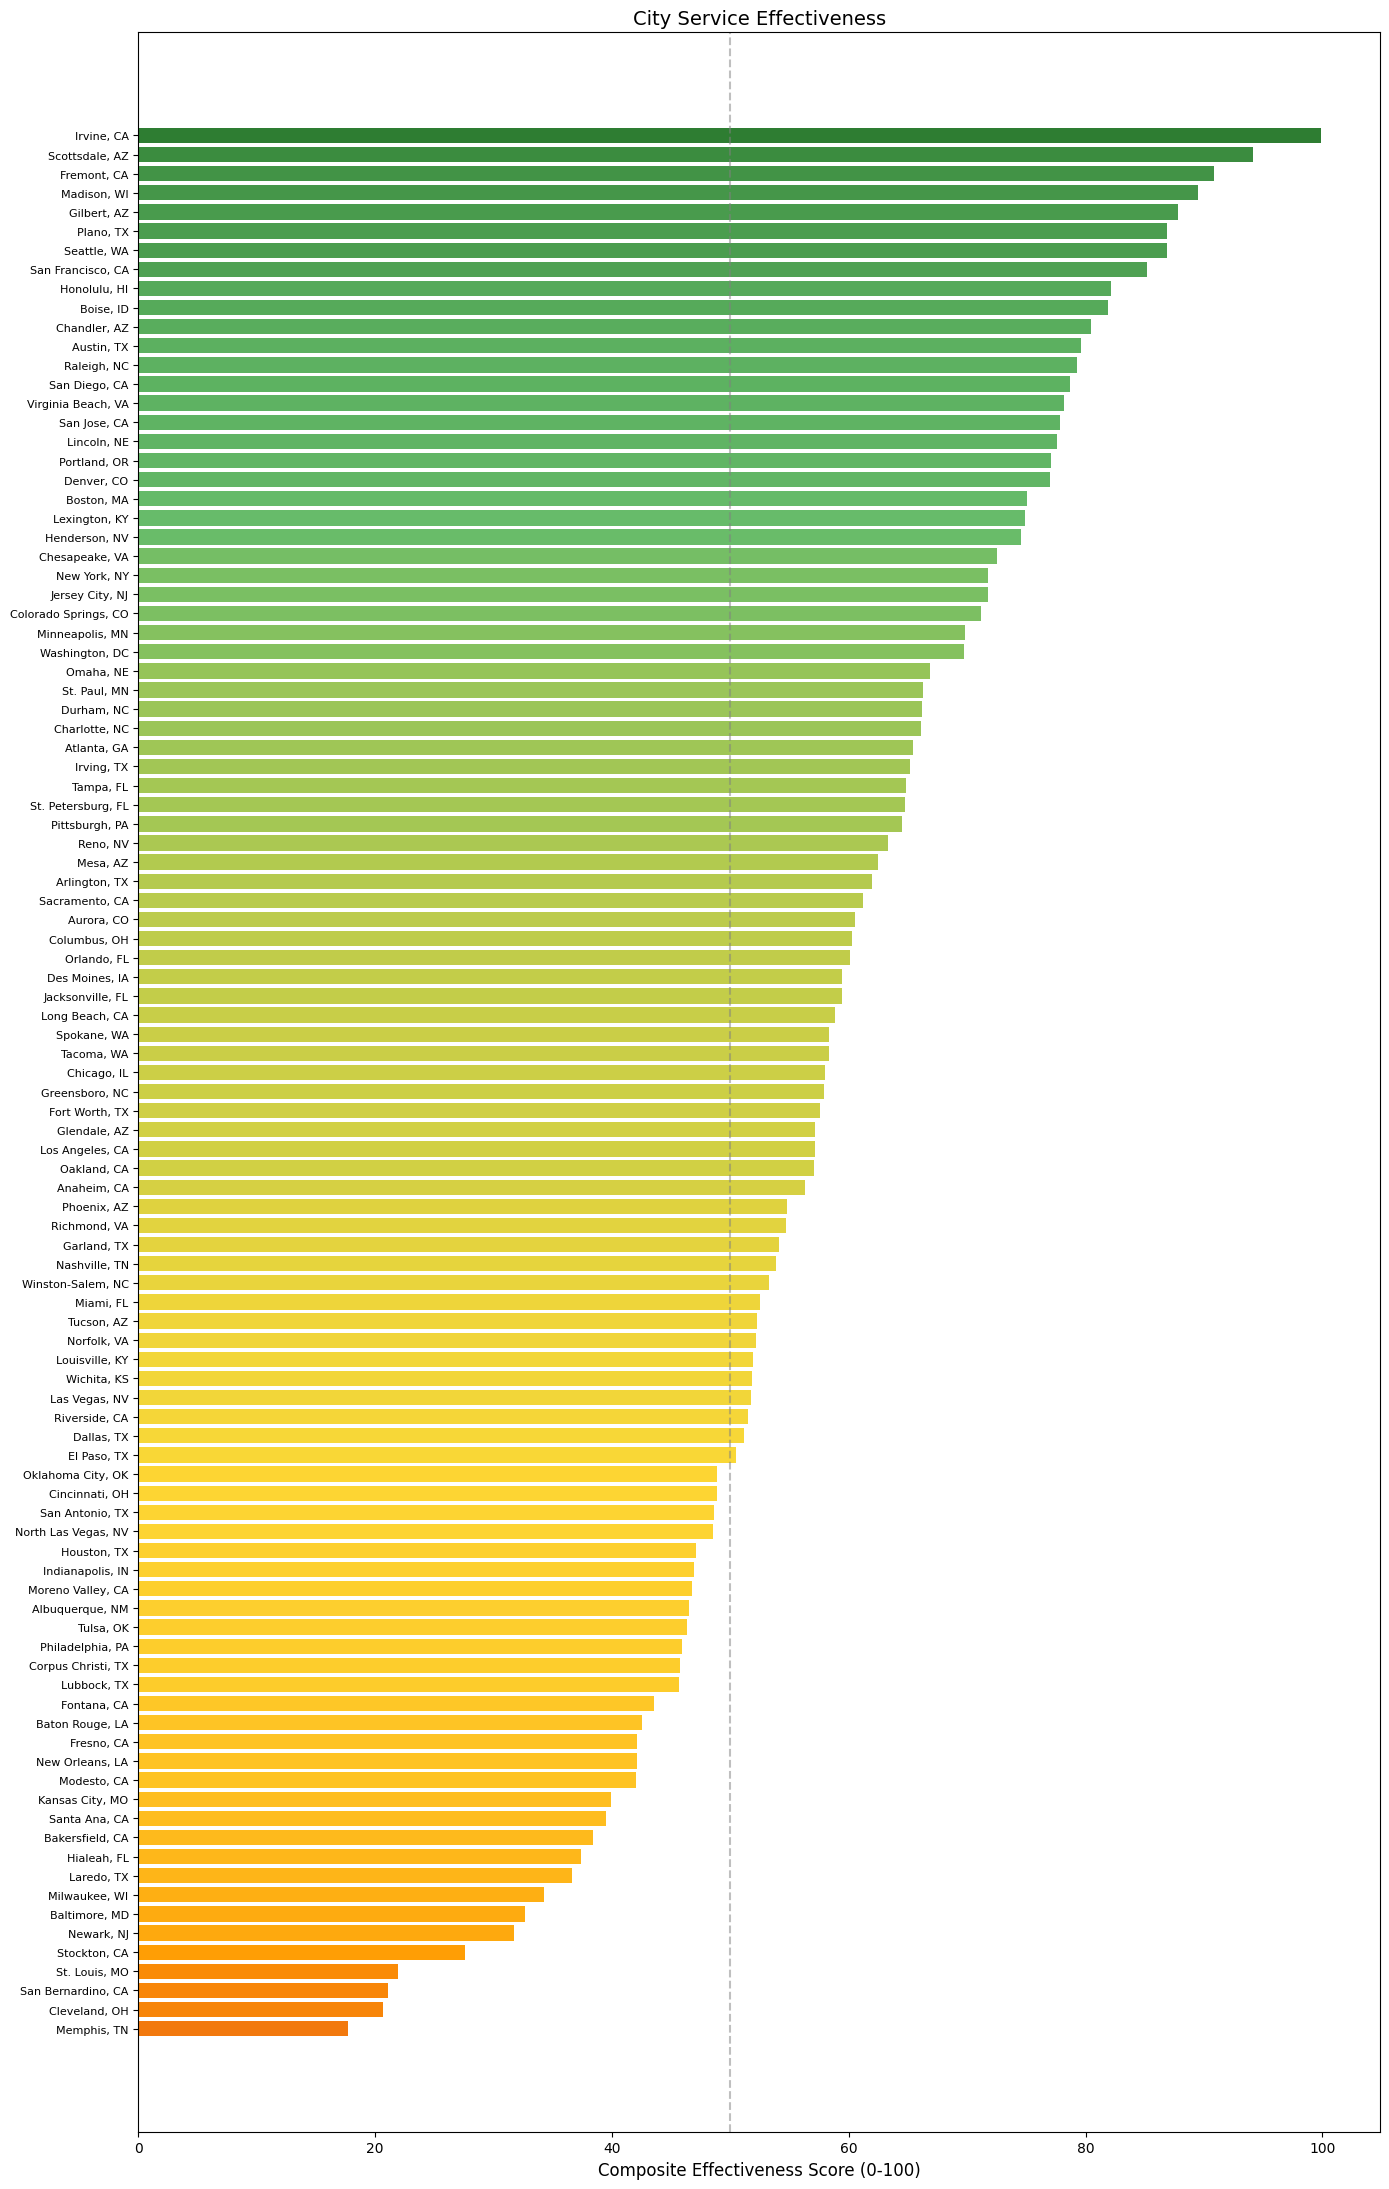

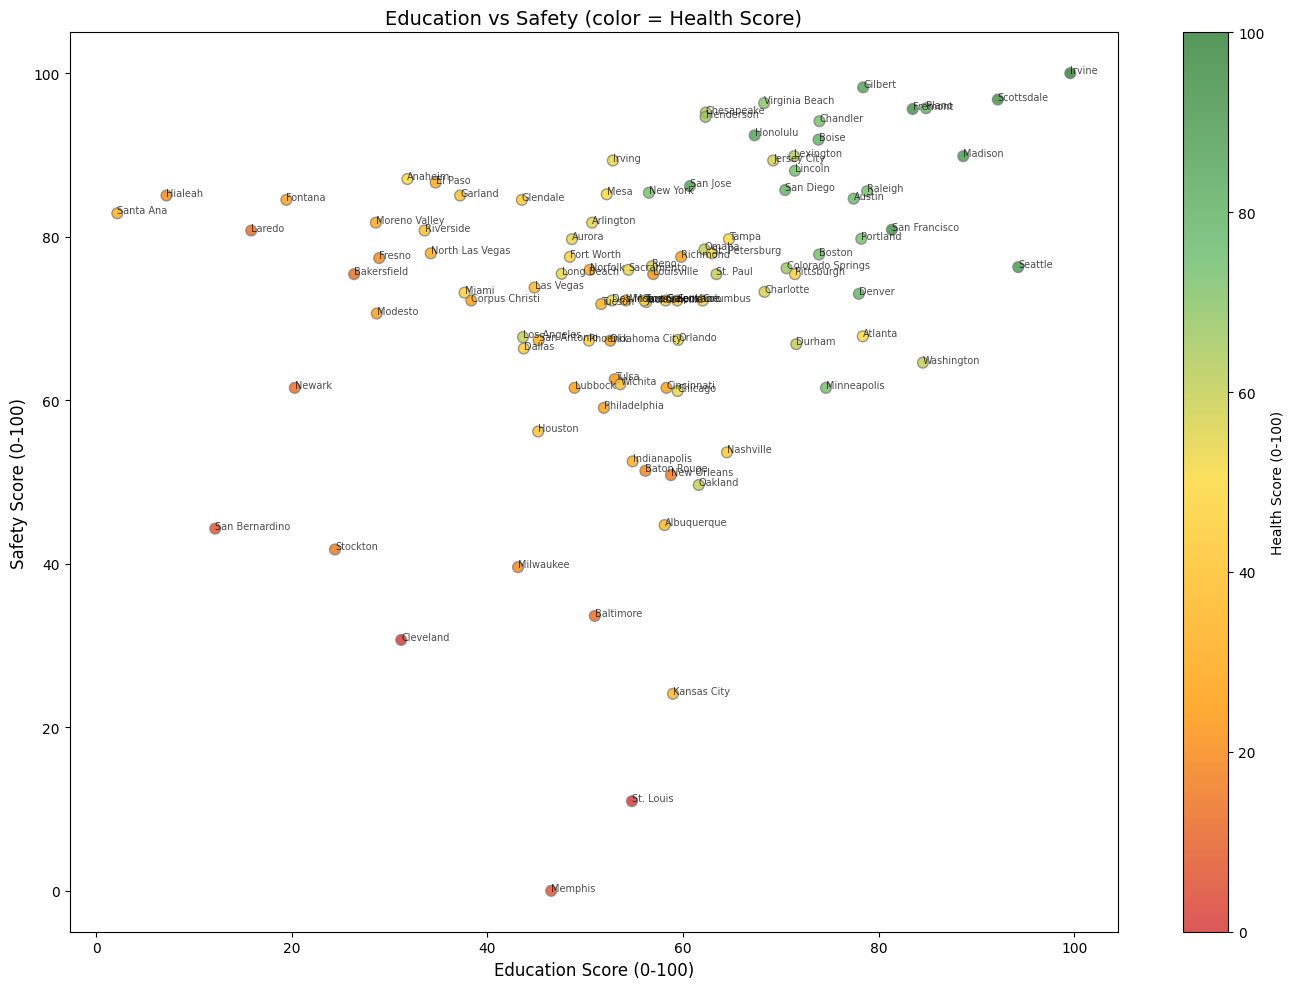

In [7]:
from matplotlib.colors import LinearSegmentedColormap
SCORE_CMAP = LinearSegmentedColormap.from_list("score", ["#d32f2f", "#ff9800", "#fdd835", "#66bb6a", "#2e7d32"])

# 1. Bar chart \u2014 composite scores
fig, ax = plt.subplots(figsize=(14, 22))
plot_data = out.sort_values("composite_score", ascending=True)
colors = SCORE_CMAP(plot_data["composite_score"] / 100)
ax.barh(plot_data["city_state"], plot_data["composite_score"], color=colors)
ax.set_xlabel("Composite Effectiveness Score (0-100)", fontsize=12)
ax.set_title("City Service Effectiveness", fontsize=14)
ax.axvline(x=50, color="gray", linestyle="--", alpha=0.5)
ax.tick_params(axis="y", labelsize=8)
plt.tight_layout()
plt.show()

# 2. Scatter \u2014 education vs safety
fig, ax = plt.subplots(figsize=(14, 10))
sc = ax.scatter(out["education_score"], out["safety_score"],
                c=out["health_score"], cmap=SCORE_CMAP, s=60, alpha=0.8, edgecolors="gray")
for _, row in out.iterrows():
    ax.annotate(row["city_state"].split(",")[0], (row["education_score"], row["safety_score"]),
                 fontsize=7, alpha=0.7)
ax.set_xlabel("Education Score (0-100)", fontsize=12)
ax.set_ylabel("Safety Score (0-100)", fontsize=12)
ax.set_title("Education vs Safety (color = Health Score)", fontsize=14)
plt.colorbar(sc, ax=ax, label="Health Score (0-100)")
plt.tight_layout()
plt.show()

In [8]:
import plotly.express as px

SCORE_SCALE = [[0, "#d32f2f"], [0.25, "#ff9800"], [0.5, "#fdd835"], [0.75, "#66bb6a"], [1, "#2e7d32"]]

fig = px.scatter_geo(
    out,
    lat="lat",
    lon="lon",
    color="composite_score",
    size="population",
    color_continuous_scale=SCORE_SCALE,
    range_color=[0, 100],
    scope="usa",
    hover_name="city_state",
    hover_data={
        "lat": False,
        "lon": False,
        "composite_score": ":.1f",
        "education_score": ":.1f",
        "safety_score": ":.1f",
        "health_score": ":.1f",
        "population": ":,.0f",
    },
    labels={
        "composite_score": "Composite (0-100)",
        "education_score": "Education (0-100)",
        "safety_score": "Safety (0-100)",
        "health_score": "Health (0-100)",
        "population": "Population",
    },
    title="City Service Effectiveness \u2014 Composite Score",
    size_max=30,
)
fig.update_layout(
    coloraxis_colorbar=dict(title="Score"),
    geo=dict(lakecolor="rgb(255,255,255)"),
)
fig.show()